In [3]:
!pip install itk  SimpleITK

You are using pip version 18.1, however version 19.1 is available.
You should consider upgrading via the 'pip install --upgrade pip' command.


In [33]:
import itk
import SimpleITK as sitk
import mri_helpers as mh
from ipywidgets import interact, fixed
import numpy as np

In [6]:
# Load the images
decide = sitk.ReadImage('MR_T1_TSE.mha')
brats = sitk.ReadImage('VSD.Brain.XX.O.MR_T1.54609.mha')

In [7]:
# Show metadata for the two images
print(decide.GetSpacing())
print(brats.GetSpacing())

(0.57292, 0.57292, 3.9)
(1.0, 1.0, 1.0)


In [8]:
mh.myshow(decide);

interactive(children=(IntSlider(value=14, description='z', max=29), Output()), _dom_classes=('widget-interact'…

In [9]:
mh.myshow(brats);

interactive(children=(IntSlider(value=77, description='z', max=154), Output()), _dom_classes=('widget-interact…

In [30]:
def resample(image, transform, is_label):
    # Output image Origin, Spacing, Size, Direction are taken from the reference
    # image in this call to Resample
    
    interpolator = sitk.sitkCosineWindowedSinc if not is_label else sitk.sitkNearestNeighbor
    default_value = 100.0
    
    # Building the transformation grid
    extreme_coords = [(0,0,0),                 (0,0,image.GetDepth()),
                      (image.GetWidth(),0,0),  (image.GetWidth(),0,image.GetDepth()),
                      (image.GetWidth(),image.GetHeight(), 0), (image.GetWidth(),image.GetHeight(), image.GetDepth()),
                      (0,image.GetHeight(), 0), (0,image.GetHeight(), image.GetDepth())
                     ]
    
   
    
    
    
    
    euler2d = sitk.Euler2DTransform()
    # Why do we set the center?
    euler2d.SetCenter(logo.TransformContinuousIndexToPhysicalPoint(np.array(logo.GetSize())/2.0))
    interact(resample_display, image=fixed(logo), euler2d_transform=fixed(euler2d), tx=(-128.0, 128.0,2.5), ty=(-64.0, 64.0), theta=(-np.pi/4.0,np.pi/4.0));
    
    euler2d.SetCenter(logo.TransformContinuousIndexToPhysicalPoint(np.array(logo.GetSize())/2.0))
    
    tx = 64
    ty = 32
    euler2d.SetTranslation((tx, ty))

    
    inv_euler2d = euler2d.GetInverse()

    extreme_points_transformed = [inv_euler2d.TransformPoint(pnt) for pnt in extreme_points]
    min_x = min(extreme_points_transformed)[0]
    min_y = min(extreme_points_transformed, key=lambda p: p[1])[1]
    max_x = max(extreme_points_transformed)[0]
    max_y = max(extreme_points_transformed, key=lambda p: p[1])[1]

    # Use the original spacing (arbitrary decision).
    output_spacing = logo.GetSpacing()
    # Identity cosine matrix (arbitrary decision).   
    output_direction = [1.0, 0.0, 0.0, 1.0]
    # Minimal x,y coordinates are the new origin.
    output_origin = [min_x, min_y]
    # Compute grid size based on the physical size and spacing.
    output_size = [int((max_x-min_x)/output_spacing[0]), int((max_y-min_y)/output_spacing[1])]

    resampled_image = sitk.Resample(logo, output_size, euler2d, sitk.sitkLinear, output_origin, output_spacing, output_direction)
    
    
    
    return sitk.Resample(image, reference_image, transform,
                         interpolator, default_value)

def affine_scale(img, transform, dimension, x_scale=3.0, y_scale=0.7):
    new_transform = sitk.AffineTransform(transform)
    matrix = np.array(transform.GetMatrix()).reshape((dimension,dimension))
    matrix[0,0] = x_scale
    matrix[1,1] = y_scale
    new_transform.SetMatrix(matrix.ravel())
    resampled = resample(img, new_transform)
    mh.myshow(resampled, 'Scaled')
    print(matrix)
    return new_transform

In [31]:
def scale_to_unitary_spacing(mri, is_label):
    dimension = 3
    affine = sitk.AffineTransform(dimension)
    # Set the scaling for the transformation to match Spacing = 1.0
    matrix = np.array(affine.GetMatrix()).reshape((dimension,dimension))
    for d in range(dimension):
        matrix[d,d] = 1.0/mri.GetSpacing()[d]
    affine.SetMatrix(matrix.ravel())
    return resample(mri, affine, is_label)


In [32]:
rescaled = scale_to_unitary_spacing(decide, False)

NameError: name 'logo' is not defined

In [39]:
mh.myshow(rescaled)

interactive(children=(IntSlider(value=14, description='z', max=29), Output()), _dom_classes=('widget-interact'…

In [40]:
mh.myshow(decide)

interactive(children=(IntSlider(value=14, description='z', max=29), Output()), _dom_classes=('widget-interact'…

In [25]:
def resample_v2(inputImage, outputImage, scale):
    PixelType = itk.UC
    ScalarType = itk.D
    Dimension = 2

    ImageType = itk.Image[PixelType, Dimension]

    ReaderType = itk.ImageFileReader[ImageType]
    reader = ReaderType.New()
    reader.SetFileName(inputImage)
    reader.Update()

    inputImage = reader.GetOutput()

    size = inputImage.GetLargestPossibleRegion().GetSize()
    spacing = inputImage.GetSpacing()

    centralPixel = itk.Index[Dimension]()
    centralPixel[0] = int(size[0] / 2)
    centralPixel[1] = int(size[1] / 2)
    centralPoint = itk.Point[ScalarType, Dimension]()
    centralPoint[0] = centralPixel[0]
    centralPoint[1] = centralPixel[1]

    scaleTransform = itk.ScaleTransform[ScalarType, Dimension].New()

    parameters = scaleTransform.GetParameters()
    parameters[0] = scale
    parameters[1] = scale

    scaleTransform.SetParameters(parameters)
    scaleTransform.SetCenter(centralPoint)

    interpolatorType = itk.LinearInterpolateImageFunction[ImageType, ScalarType]
    interpolator = interpolatorType.New()

    resamplerType = itk.ResampleImageFilter[ImageType, ImageType]
    resampleFilter = resamplerType.New()

    resampleFilter.SetInput(inputImage)
    resampleFilter.SetTransform(scaleTransform)
    resampleFilter.SetInterpolator(interpolator)
    resampleFilter.SetSize(size)
    resampleFilter.SetOutputSpacing(spacing)

    WriterType = itk.ImageFileWriter[ImageType]
    writer = WriterType.New()
    writer.SetFileName(outputImage)
    writer.SetInput(resampleFilter.GetOutput())

    writer.Update()

In [28]:
# Load the images
in_path = 'MR_T1_TSE.mha'
out_path = 'MR_T1_TSE_RESCALED.mha'
resample_v2(in_path, out_path, 2)
original_mha = sitk.ReadImage(in_path)
reloaded_mha = sitk.ReadImage(out_path)
mh.myshow(original_mha)

interactive(children=(IntSlider(value=14, description='z', max=29), Output()), _dom_classes=('widget-interact'…

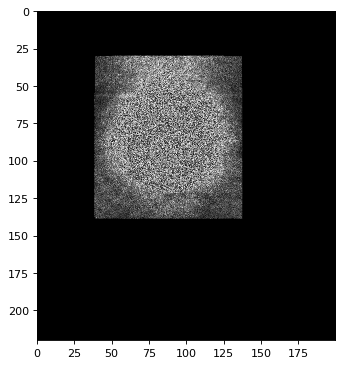

In [29]:
mh.myshow(reloaded_mha)